In [1]:
from git_root import git_root
import os
from pathlib import Path
import numpy as np

os.chdir("/Users/kevinklein/Code/life-monitor")

from monitoring import cal, setup, utils, yearly

_FIRST_YEAR = 2021
_LAST_YEAR = 2023

import yaml

with open("env-vars.yaml", "r") as stream:
    try:
        env_vars = yaml.safe_load(stream)
        for key, value in env_vars.items():
            os.environ[key] = value
    except yaml.YAMLError as exc:
        print(exc)

In [2]:
def _get_df(sport):
    service = setup.get_calendar_service()
    start = utils.first_of_jan_timestamp(year=_FIRST_YEAR)
    end = utils.last_of_dec_timestamp(year=_LAST_YEAR)
    events = cal.get_filtered_events(
        service,
        start,
        end,
        "summary",
        filter_value=sport,
    )
    y = cal.prune_events(events)

    df = cal.get_dataframe(events)
    return df

In [3]:
def _get_df_exercise():
    service = setup.get_calendar_service()
    start = utils.first_of_jan_timestamp(year=_FIRST_YEAR)
    end = utils.last_of_dec_timestamp(year=_LAST_YEAR)
    events = cal.get_filtered_events(
        service,
        start,
        end,
        "color",
        filter_value="4",
    )
    y = cal.prune_events(events)
    df = cal.get_dataframe(events)
    
    def is_endurance(title: str) -> bool:
        return title in ["running", "cross-country skiing", "cycling", "tennis", "hiking", "swimming", 
                         "snowshoe hiking", "inline skating", "elliptical", "padel", "elliptical"]
    
    def is_strength(title: str) -> bool:
        return title in ["gym", "climbing", "gym: ub", "gym: c", "gym: lb", "via ferrata"]

    df["endurance"] = df["title"].apply(is_endurance)
    df["strength"] = df["title"].apply(is_strength)
    return df

In [4]:
import matplotlib.pyplot as plt

def _relative_frequency_plot(probabilities, fig, ax):
    disciplines = list(sorted(probabilities[2023].keys(), key=lambda d: probabilities[2023][d], reverse=True))
    n_disciplines = len(disciplines)
    for year in [2023, 2022]:
        values = [probabilities[year][discipline] for discipline in disciplines]
        ax.bar(range(n_disciplines), values, align='center', label=str(year), alpha=.3)
    ax.set_xticks(range(n_disciplines), disciplines, rotation="vertical")
    ax.legend()
    fig.tight_layout()

In [5]:
dfs = {}
for sport in [utils.Sport.running, utils.Sport.cycling, utils.Sport.gym, utils.Sport.climbing]:
    dfs[sport] = _get_df(sport)

In [6]:
df_exercise = _get_df_exercise()

# Individual disciplines

### Climbing

In [7]:
dfs[utils.Sport.climbing].groupby("year")["title"].count()

year
2021     1
2022     7
2023    29
Name: title, dtype: int64

### Gym

In [8]:
gym = dfs[utils.Sport.gym]

In [9]:
gym[gym["year"] == 2023]["title"].value_counts()

title
gym: ub    62
gym: c     36
gym: lb    16
Name: count, dtype: int64

In [10]:
gym.groupby("year")["title"].count()

year
2021     82
2022    113
2023    114
Name: title, dtype: int64

### Running

In [11]:
dfs[utils.Sport.running].groupby("year")["distance"].sum()

year
2021    1394.18
2022    1147.05
2023    1311.93
Name: distance, dtype: float64

In [12]:
dfs[utils.Sport.running].groupby("year")["distance"].count()

year
2021    125
2022    127
2023    139
Name: distance, dtype: int64

In [13]:
dfs[utils.Sport.running].groupby("year")["distance"].median()

year
2021    10.00
2022     8.90
2023     8.35
Name: distance, dtype: float64

In [14]:
df_exercise.groupby("year")["title"].agg(lambda x: x[x == "running"].count() / x.count())

year
2021    0.542735
2022    0.389571
2023    0.397183
Name: title, dtype: float64

/Users/kevinklein/Code/life-monitor/monitoring/cal.py:432: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


PosixPath('/Users/kevinklein/Code/life-monitor/cumulative_running.png')

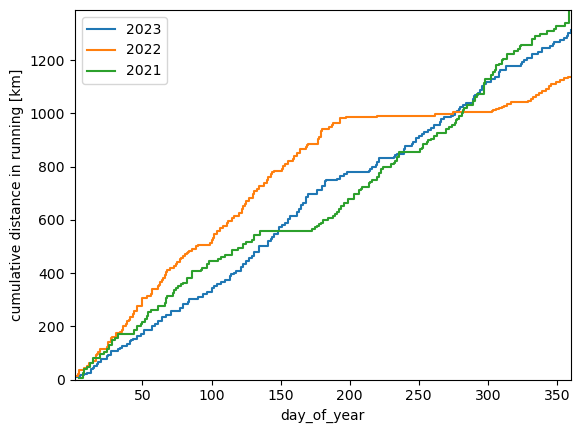

In [15]:
cal.plot_cumulative_day_distances(dfs[utils.Sport.running], utils.Sport.running, Path(git_root()))

### Cycling

In [16]:
dfs[utils.Sport.cycling].groupby("year")["distance"].sum()

year
2021     624.17
2022    1312.83
2023    1264.37
Name: distance, dtype: float64

In [17]:
dfs[utils.Sport.cycling].groupby("year")["distance"].count()

year
2021    17
2022    35
2023    41
Name: distance, dtype: int64

/Users/kevinklein/Code/life-monitor/monitoring/cal.py:432: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


PosixPath('/Users/kevinklein/Code/life-monitor/cumulative_cycling.png')

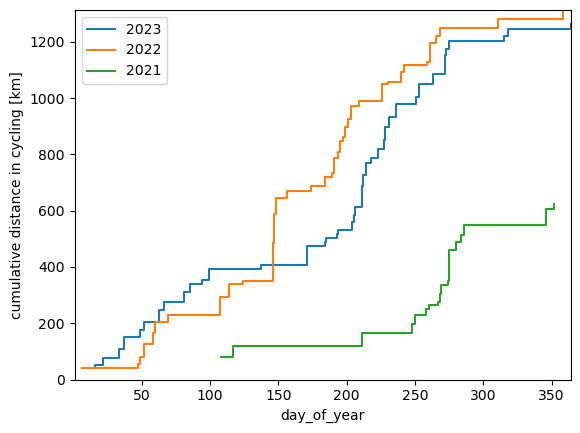

In [18]:
cal.plot_cumulative_day_distances(dfs[utils.Sport.cycling], utils.Sport.cycling, Path(git_root()))

# Overall exercise

In [19]:
year_counts = df_exercise.groupby("year")["title"].count().to_dict()
year_counts

{2021: 234, 2022: 326, 2023: 355}

In [20]:
df_exercise.groupby("year")["title"].nunique()

year
2021    11
2022    17
2023    16
Name: title, dtype: int64

In [21]:
probabilities, entropies = yearly.variety(df_exercise)

Text(0.5, 1.0, 'Relative frequencies of various disciplines')

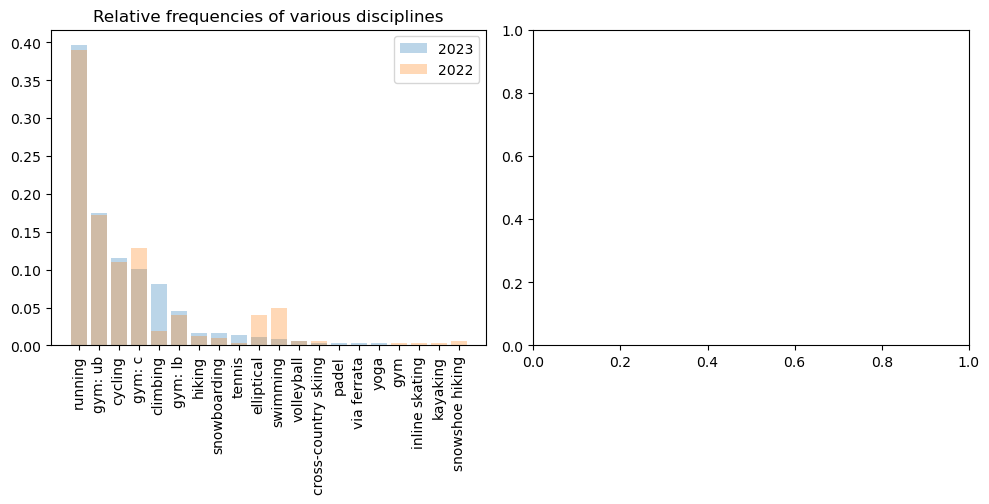

In [22]:
fig_context, axs_context = plt.subplots(ncols=2, figsize=(10, 5))
_relative_frequency_plot(probabilities, fig_context, axs_context[0])
axs_context[0].set_title("Relative frequencies of various disciplines")

### Setup for radar plot

In [23]:
endurances = {k: v / 365 for k, v in df_exercise.groupby("year")["endurance"].sum().to_dict().items()}
endurances

{2021: 0.4136986301369863, 2022: 0.5534246575342465, 2023: 0.5534246575342465}

In [24]:
strengths = {k: v / 365 for k,v in df_exercise.groupby("year")["strength"].sum().to_dict().items()}
strengths

{2021: 0.2273972602739726, 2022: 0.3232876712328767, 2023: 0.39452054794520547}

In [25]:
from math import log
max_entropy = log(len(probabilities[2022]), 2)
varieties = {k: v/max_entropy for k, v in entropies.items()}
varieties

{2021: 0.44959659976831556, 2022: 0.6400743446628605, 2023: 0.6280172631844656}

In [26]:
from collections import defaultdict
durations_h = df_exercise["date"].diff().dt.total_seconds() / 3600
df_exercise_aux = df_exercise.copy()
df_exercise_aux["durations"] = durations_h
consistencies = df_exercise_aux.groupby("year")["durations"].std().to_dict()
consistencies = {k: v/96 for k,v in consistencies.items()}
consistencies

{2021: 0.36650846379260044, 2022: 0.3007684694468051, 2023: 0.1636355287514836}

In [27]:
# Inverting the order to make sure color-coding checks out.
df_exercise_aux.iloc[::-1].groupby("year", sort=False)["durations"].hist(
    ax=axs_context[1], figure=fig_context, legend=True, bins=20, alpha=.3
)
axs_context[1].set_title("Durations [h] between two consecutive exercise activities")
axs_context[1].legend()

<Figure size 640x480 with 0 Axes>

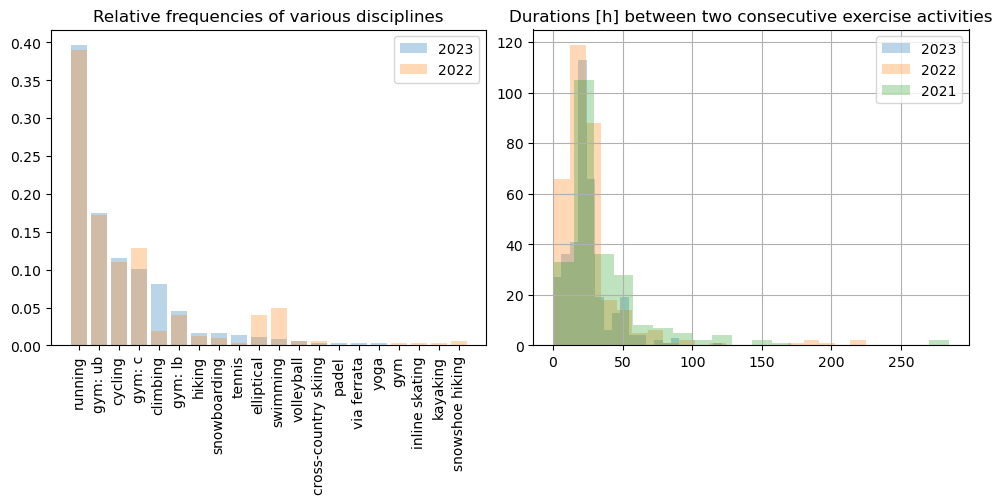

In [28]:
fig_context.savefig("context.svg")
fig_context

In [29]:
labels = {
    "Endurance": [0, .25, .5, .75, 1],
    "Variety": [0, round(max_entropy/4, 2), round(max_entropy/2, 2), round(max_entropy*3/4, 2), round(max_entropy,2)],
    "Strength": [0, .25, .5, .75, 1],
    "Consistency": [96, 62, 48, 24, 0],
}

In [30]:
dimensions = ["Endurance",  "Variety", "Strength", "Consistency"]
n_dimensions = len(dimensions)
radar_years = [2023, 2022, 2021]
radar_data = {year: [endurances[year], varieties[year], strengths[year], (1-consistencies[year])] for year in radar_years}

In [31]:
colors = ["b", "r", "g"]

### Radar plot

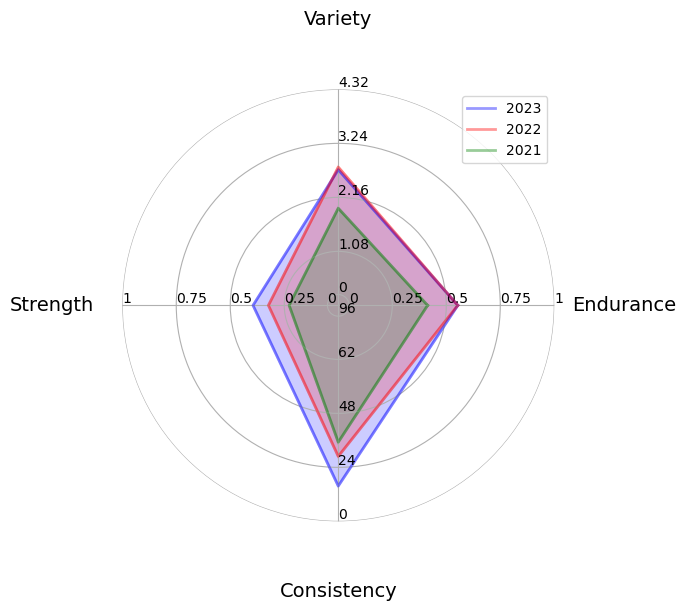

In [32]:
fig = plt.figure()
radar = yearly.Radar(fig, dimensions, labels.values())
for year, color in zip(radar_years, colors):
    radar.plot(radar_data[year], '-', lw=2, color=color, alpha=0.4, label=year)
    radar.fill(radar_data[year], lw=2, color=color, alpha=.2)
radar.ax.legend()
radar.ax.tick_params(pad=40)
fig.savefig("radar.svg", bbox_inches='tight')